# Basic Statistics of NOAA-GridSat-B1

In this notebook, we develop the utilities for deriving basic statistics from NOAA-GridSta-B1 dataset.


       timestamp                                               xuri
0  2014.01.01.00  ../../data/noaa/GRIDSAT-B1.2014.01.01.00.v02r0...
1  2014.01.01.03  ../../data/noaa/GRIDSAT-B1.2014.01.01.03.v02r0...
2  2014.01.01.06  ../../data/noaa/GRIDSAT-B1.2014.01.01.06.v02r0...
3  2014.01.01.09  ../../data/noaa/GRIDSAT-B1.2014.01.01.09.v02r0...
4  2014.01.01.12  ../../data/noaa/GRIDSAT-B1.2014.01.01.12.v02r0...
(858, 858)
{'mean': 270.04965, 'stdev': 18.749163, 'min': 190.47000122070312, 'pt25': 257.0199890136719, 'median': 272.9599914550781, 'pt75': 285.7900085449219, 'max': 298.6600036621094}


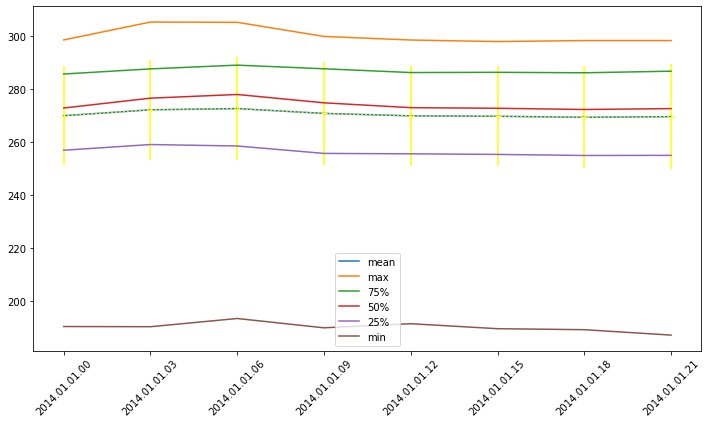

In [1]:
import numpy as np
import pandas as pd
import netCDF4 as nc

# Utility functions
def list_noaagridsatb1_files(dir, suffix='.v02r01.nc', to_remove=['GRIDSAT-B1.','.v02r01.nc']):
    ''' To scan through the sapecified dir and get the corresponding file with suffix. '''
    import os
    import pandas as pd
    xfiles = []
    for root, dirs, files in os.walk(dir):  # Loop through the directory
        for fn in files:
            if fn.endswith(suffix):         # Filter files with suffix
                timestamp = fn
                for s in to_remove:         # Removing prefix and suffix to get time-stamp
                    timestamp = timestamp.replace(s,'')
                xfiles.append({'timestamp':timestamp, 'xuri':os.path.join(root, fn)})
    return(pd.DataFrame(xfiles).sort_values('timestamp').reset_index(drop=True))


# Binary reader
def read_noaagridsatb1(furi, var='irwin_cdr', scale=0.01, offset=200, remove_na=True, crop_east_asia=True):
    ''' The method reads in a NOAA-GridSta-B1 image in netCDF4 format (.nc file). 
        The brightness temperature data was stored in int16 as 'irwin_cdr', with 
        a scal factor of 0.01 and offset of 200. The missing values is flagged as -31999.
        More details of the data is described in https://developers.google.com/earth-engine/datasets/catalog/NOAA_CDR_GRIDSAT-B1_V2.
        Since our analysis focuss on East Asia (0-60'N, 100-160'E), we used an 
        option to crop the data to this region (index: lat:1000~1858, lon:4000~4858).
        The output is a 2-d numpy array of float32 with shape (858, 858).
    '''
    import numpy as np
    import netCDF4 as nc
    # Read in data
    data = nc.Dataset(furi)
    cdr = np.array(data.variables['irwin_cdr'])*scale+offset
    # Remove missing value
    if remove_na:
        cdr[cdr<0] = offset
    # Crop domain to East-Asia (0-60'N, 100-160'E)
    if crop_east_asia:
        return(cdr[0, 1000:1858, 4000:4858])
    else:
        return(cdr[0,:,:])


def read_multiple_noaagridsatb1(flist):
    ''' This method reads in a list of NOAA-GridSat-B1 images and returns a numpy array. '''
    import numpy as np
    data = []
    for f in flist:
        data.append(read_noaagridsatb1(f))
    return(np.array(data))
    

# Statistical summary
def summarize_single_image(img):
    ''' Calculate basic statistics of one Himawari-8 image. '''
    mean = np.mean(img.flatten())
    std = np.std(img.flatten())
    pt = np.percentile(img.flatten(), [0, 25, 50, 75,100])
    return({'mean':mean, 'stdev':std, 'min':pt[0],'pt25':pt[1],'median':pt[2],'pt75':pt[3], 'max':pt[4]})

def statistics_by_image(datainfo):
    ''' Given the data information, derive the statistics by image. '''
    list_stats = []
    for i in range(datainfo.shape[0]):
        row = datainfo.iloc[i,:]
        tmp = read_noaagridsatb1(row['xuri'])
        stats = summarize_single_image(tmp)
        stats['timestamp'] = row['timestamp']
        list_stats.append(stats)
    return(pd.DataFrame(list_stats).sort_values('timestamp').reset_index(drop=True))

# Test
files = list_noaagridsatb1_files('../../data/noaa/')
print(files.head())

tmp = read_noaagridsatb1(files['xuri'].iloc[0])
print(tmp.shape)
print(summarize_single_image(tmp))

dfstats = statistics_by_image(files)

%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))

plt.plot(dfstats['mean'], label='mean')
plt.plot(dfstats['max'], label='max')
plt.plot(dfstats['pt75'], label='75%')
plt.plot(dfstats['median'], label='50%')
plt.plot(dfstats['pt25'], label='25%')
plt.plot(dfstats['min'], label='min')
plt.errorbar(np.arange(dfstats.shape[0]),dfstats['mean'],dfstats['stdev'], color='yellow', linestyle=':', marker='+')
plt.xticks(np.arange(0, dfstats.shape[0], 1), dfstats['timestamp'][np.arange(0, dfstats.shape[0], 1)], rotation=45)

plt.legend()
plt.tight_layout()
plt.show()

dict_keys(['mean', 'stdev'])


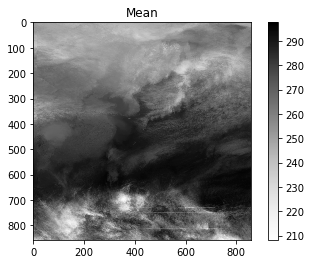

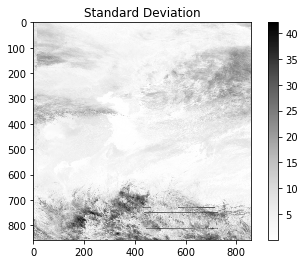

In [2]:
# Per-grid analysis
def summarize_by_grid(data):
    ''' Given a 3D numpy array, calculate the mean and variance on the first axis. '''
    mean_image = np.mean(data, axis=0)
    var_image = np.var(data, axis=0)
    return({'mean':mean_image, 'variance':var_image})

def summarize_noaagridsatb1_by_grid(flist, batch_size=None, shuffle=True, rseed=123):
    ''' Calculate grid-by-grid statistics of a list of Himawari-8 images. '''
    if batch_size is None:  # Read in all data
        data = read_multiple_noaagridsatb1(flist)
        tmp = summarize_by_grid(data)
        summary={'mean':tmp['mean'], 'stdev':np.sqrt(tmp['variance'])}
    else:                   # Read in data by batch
        # Shuffle flist for random batching
        if shuffle:
            flist = flist.sample(frac=1, random_state=rseed).reset_index(drop=True)
            #logging.debug('Shuffling the input data for batch processing.')
        pooled_mean = None
        pooled_var = None
        nSample = len(flist)
        batch_start = 0
        batch_end = batch_size
        batch_count = 0
        # Loop through all files
        while batch_start < nSample:
            limit = min(batch_end, nSample)
            #logging.debug("Batch "+str(batch_count)+', size:'+str(limit-batch_start))
            data = read_multiple_noaagridsatb1(flist[batch_start:limit])
            #logging.debug(flist[batch_start])
            # calculate statistics by increment
            tmp = summarize_by_grid(data)
            if pooled_mean is None:
                pooled_mean = (limit - batch_start)*tmp['mean']
                pooled_var = (limit - batch_start - 1)*tmp['variance']
            else:
                pooled_mean += (limit - batch_start)*tmp['mean']
                pooled_var += (limit - batch_start - 1)*tmp['variance']
            # increment
            batch_start += batch_size   
            batch_end += batch_size
            batch_count += 1
        # Pooling
        pooled_mean = pooled_mean/nSample
        pooled_var = pooled_var/(nSample-batch_count)
        summary={'mean':pooled_mean, 'stdev':np.sqrt(pooled_var)}
    # 
    return(summary)


# Test
stats_by_grid = summarize_noaagridsatb1_by_grid(files['xuri'])
print(stats_by_grid.keys())

%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(np.flipud(stats_by_grid['mean']), alpha=0.99, cmap='Greys')
plt.title('Mean')
plt.colorbar()
plt.show()

plt.imshow(np.flipud(stats_by_grid['stdev']), alpha=0.99, cmap='Greys')
plt.title('Standard Deviation')
plt.colorbar()
plt.show()

## Results from Larger Dataset

For the year 2002:

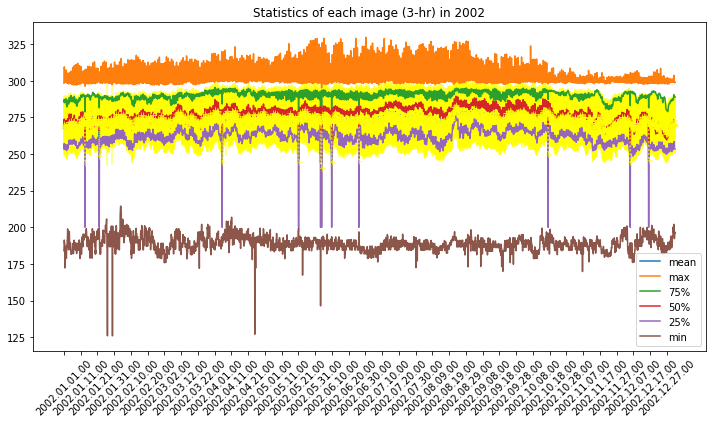

C:\Users\tsyo\anaconda3\lib\site-packages\ipykernel_launcher.py:40: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


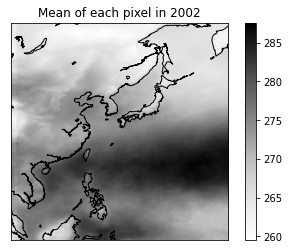

C:\Users\tsyo\anaconda3\lib\site-packages\ipykernel_launcher.py:47: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


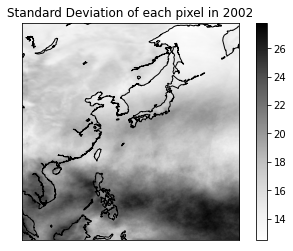

In [4]:
import numpy as np
import pandas as pd
import pickle

# By image
stats_by_image = pd.read_csv('../../workspace/noaa/noaa_2002.stats_by_image.csv')

%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))

plt.plot(stats_by_image['mean'], label='mean')
plt.plot(stats_by_image['max'], label='max')
plt.plot(stats_by_image['pt75'], label='75%')
plt.plot(stats_by_image['median'], label='50%')
plt.plot(stats_by_image['pt25'], label='25%')
plt.plot(stats_by_image['min'], label='min')
plt.errorbar(np.arange(stats_by_image.shape[0]),stats_by_image['mean'],stats_by_image['stdev'], color='yellow', alpha=0.6, linestyle=':', marker='+')
plt.xticks(np.arange(0, stats_by_image.shape[0], 80), stats_by_image['timestamp'][np.arange(0, stats_by_image.shape[0], 80)], rotation=45)

plt.title('Statistics of each image (3-hr) in 2002')
plt.legend()
plt.tight_layout()
plt.show()

# By grid
mean_by_grid = np.fromfile('../../workspace/noaa/noaa_2002_mean.npy', 'float32').reshape((858,858))
stdev_by_grid = np.fromfile('../../workspace/noaa/noaa_2002_std.npy', 'float32').reshape((858,858))

%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

lat0 = 0.0
lat1 = 60.059998
lon0 = 100.0
lon1 = 160.06

m = Basemap(llcrnrlon=lon0, urcrnrlon=lon1, llcrnrlat=lat0, urcrnrlat=lat1, resolution='l')
m.drawcoastlines()
m.imshow(mean_by_grid, alpha=0.99, cmap='Greys')
plt.title('Mean of each pixel in 2002')
plt.colorbar()
plt.show()

m = Basemap(llcrnrlon=lon0, urcrnrlon=lon1, llcrnrlat=lat0, urcrnrlat=lat1, resolution='l')
m.drawcoastlines()
m.imshow(stdev_by_grid, alpha=0.99, cmap='Greys')
plt.title('Standard Deviation of each pixel in 2002')
plt.colorbar()
plt.show()

## Multi-year comparison

We run the same analysis through many years and compare them together.

(61270, 8)
         mean      stdev         min        pt25      median        pt75  \
0  271.999023  20.598471  206.750000  254.330002  275.970001  291.809998   
1  274.651245  19.432997  209.669998  258.600006  279.290009  293.040009   
2  275.428986  19.386612  207.649994  259.269989  280.880005  293.290009   
3  273.564209  20.176924  199.869995  255.729996  277.979980  293.000000   
4  272.935883  20.010900  202.031296  254.679993  277.100006  292.279999   

          max      timestamp  
0  299.359985  1998.01.01.00  
1  307.299988  1998.01.01.03  
2  312.359985  1998.01.01.06  
3  306.549988  1998.01.01.09  
4  299.799988  1998.01.01.12  


No handles with labels found to put in legend.


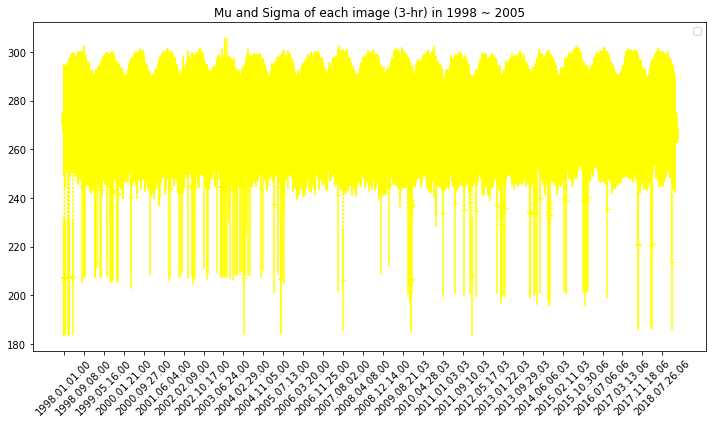

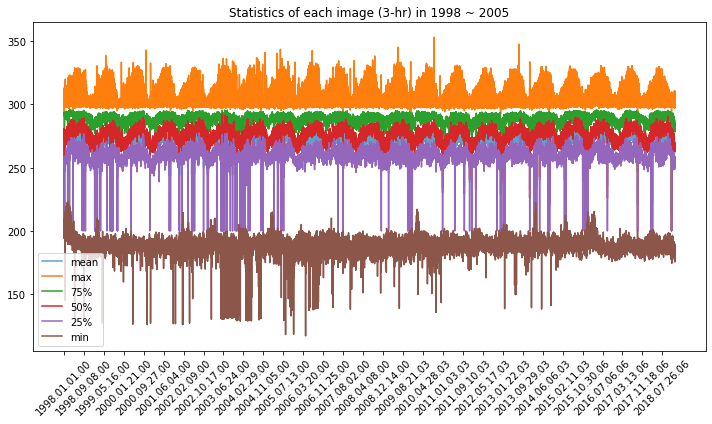

In [9]:
# Define years
years = np.arange(1998, 2019)
# Read and stack data
stats_by_image = pd.read_csv('../../workspace/noaa/noaa_'+str(years[0])+'.stats_by_image.csv')
for y in years[1:]:
    tmp = pd.read_csv('../../workspace/noaa/noaa_'+str(y)+'.stats_by_image.csv')
    stats_by_image = pd.concat([stats_by_image, tmp])
#
stats_by_image = stats_by_image.sort_values('timestamp').reset_index(drop=True)
print(stats_by_image.shape)
print(stats_by_image.head())


%matplotlib inline
import matplotlib.pyplot as plt

# Plot1
plt.figure(figsize=(10,6))
plt.errorbar(np.arange(stats_by_image.shape[0]),stats_by_image['mean'],stats_by_image['stdev'], color='yellow', linestyle=':', marker='+')
plt.xticks(np.arange(0, stats_by_image.shape[0], 2000), stats_by_image['timestamp'][np.arange(0, stats_by_image.shape[0], 2000)], rotation=45)
plt.title('Mu and Sigma of each image (3-hr) in 1998 ~ 2005')
plt.legend()
plt.tight_layout()
plt.show()

# Plot2
plt.figure(figsize=(10,6))
plt.plot(stats_by_image['mean'], alpha=0.7, label='mean')
plt.plot(stats_by_image['max'], label='max')
plt.plot(stats_by_image['pt75'], label='75%')
plt.plot(stats_by_image['median'], label='50%')
plt.plot(stats_by_image['pt25'], label='25%')
plt.plot(stats_by_image['min'], label='min')
plt.xticks(np.arange(0, stats_by_image.shape[0], 2000), stats_by_image['timestamp'][np.arange(0, stats_by_image.shape[0], 2000)], rotation=45)
plt.title('Statistics of each image (3-hr) in 1998 ~ 2005')
plt.legend()
plt.tight_layout()
plt.show()

C:\Users\tsyo\anaconda3\lib\site-packages\ipykernel_launcher.py:15: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  from ipykernel import kernelapp as app


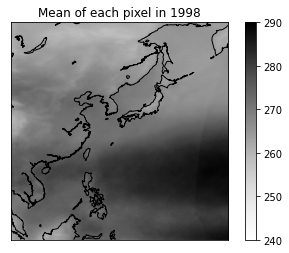

C:\Users\tsyo\anaconda3\lib\site-packages\ipykernel_launcher.py:22: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


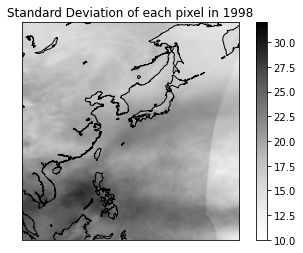

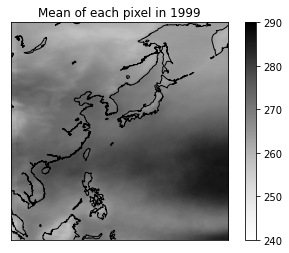

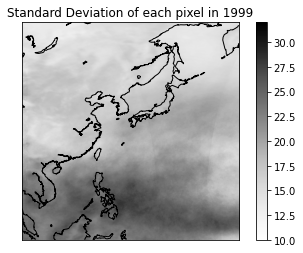

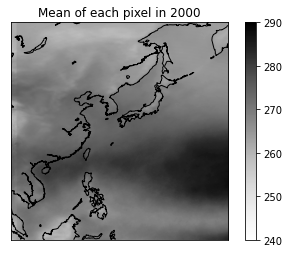

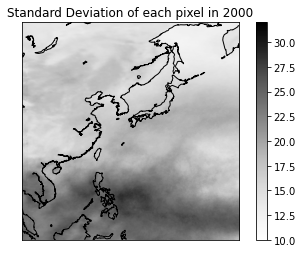

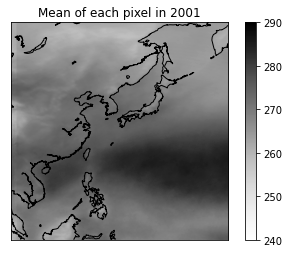

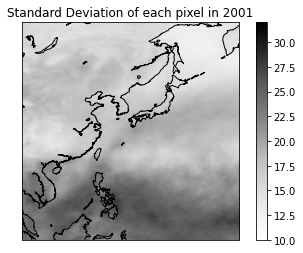

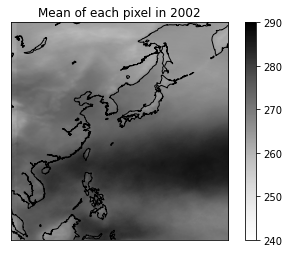

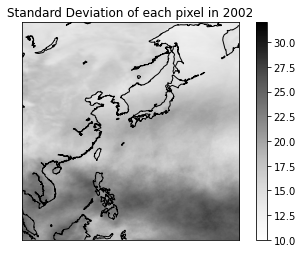

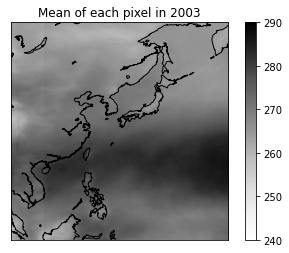

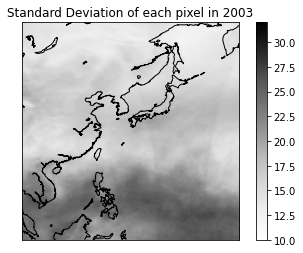

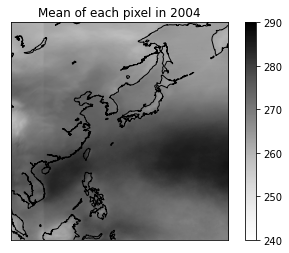

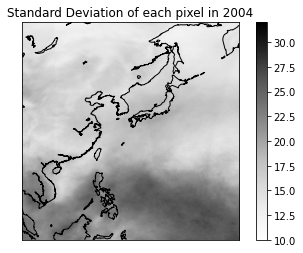

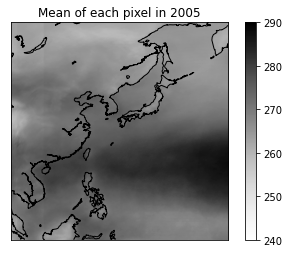

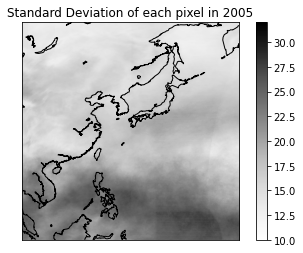

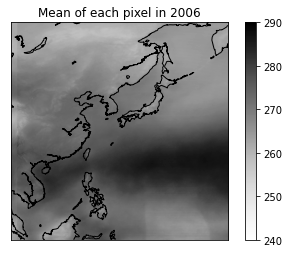

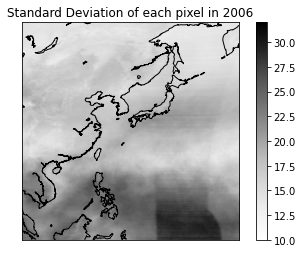

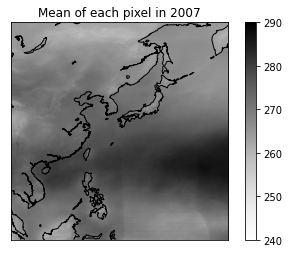

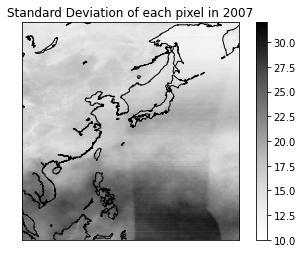

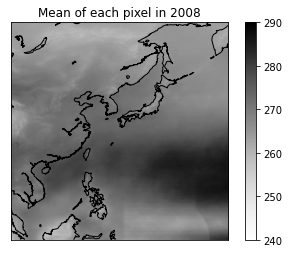

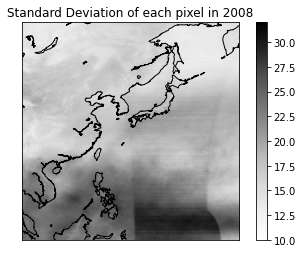

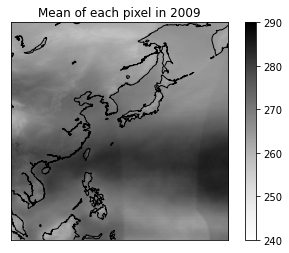

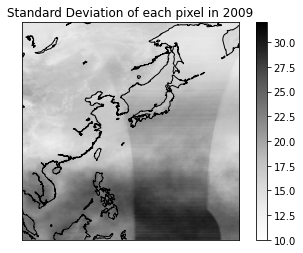

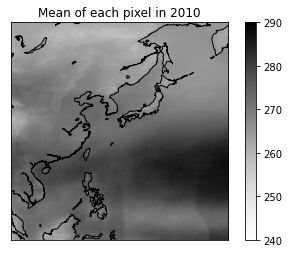

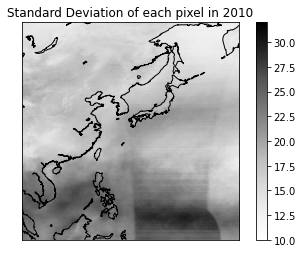

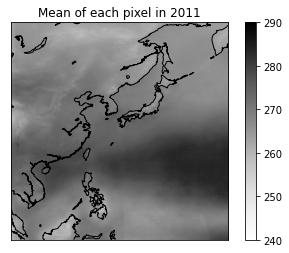

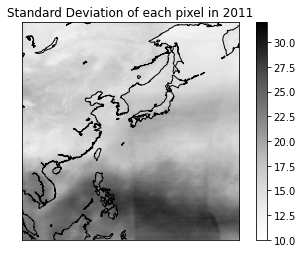

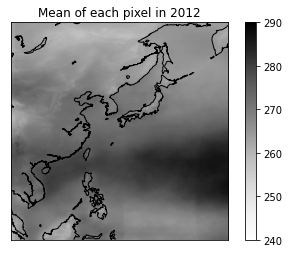

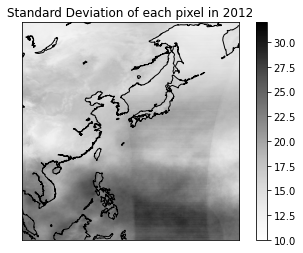

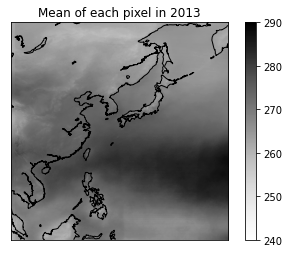

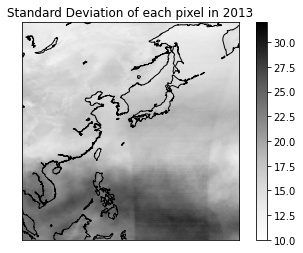

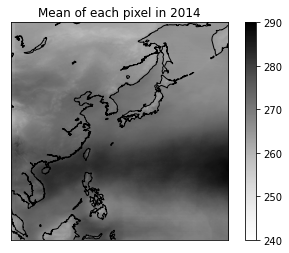

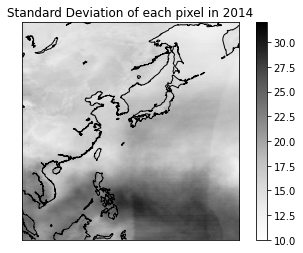

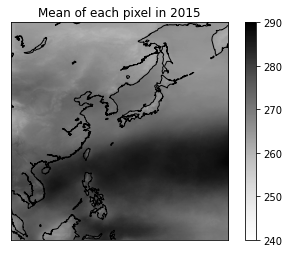

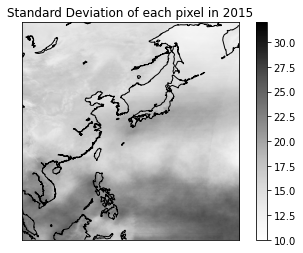

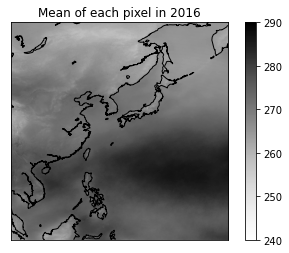

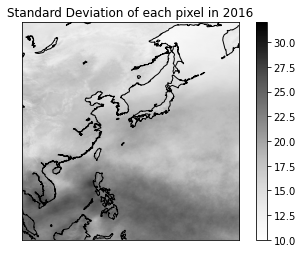

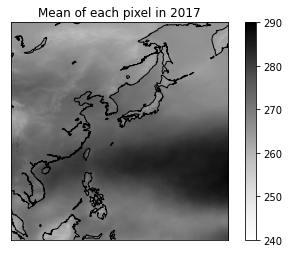

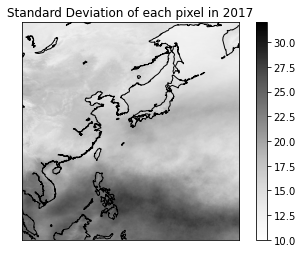

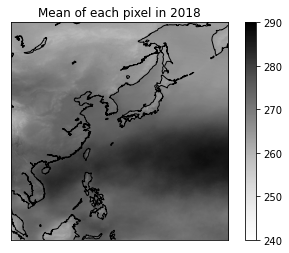

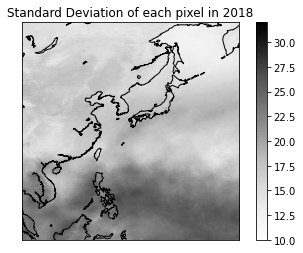

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

lat0 = 0.0
lat1 = 60.059998
lon0 = 100.0
lon1 = 160.06

# By grid
for y in years:
    mean_by_grid = np.fromfile('../../workspace/noaa/noaa_'+str(y)+'_mean.npy', 'float32').reshape((858,858))
    stdev_by_grid = np.fromfile('../../workspace/noaa/noaa_'+str(y)+'_std.npy', 'float32').reshape((858,858))

    m = Basemap(llcrnrlon=lon0, urcrnrlon=lon1, llcrnrlat=lat0, urcrnrlat=lat1, resolution='l')
    m.drawcoastlines()
    m.imshow(mean_by_grid, alpha=0.99, cmap='Greys', vmin=240, vmax=290)
    plt.title('Mean of each pixel in '+str(y))
    plt.colorbar()
    plt.show()

    m = Basemap(llcrnrlon=lon0, urcrnrlon=lon1, llcrnrlat=lat0, urcrnrlat=lat1, resolution='l')
    m.drawcoastlines()
    m.imshow(stdev_by_grid, alpha=0.99, cmap='Greys', vmin=10, vmax=32)
    plt.title('Standard Deviation of each pixel in '+str(y))
    plt.colorbar()
    plt.show()